# Makemore MLP
This Jupyter Notebook is about creating new names at a character level (character-level multilayer perceptron) following [Andrej Karpathy's](https://www.youtube.com/watch?v=TCH_1BHY58I) implementation of [Bengio's paper (2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). We explore how:
- Having two layers in a network allows more parameters, which increases the model quality overall
- We can now scale from a bigram model to a trigram model, or anything else, really!
- Use of an embedded layer
- Experimenting with multiple hyperparameters, including
  - Batch size
  - Embedded feature vector size
  - Number of iterations
  - (Initial) Learning rate
  - Number of epochs

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2026-02-07 02:11:26--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2026-02-07 02:11:27 (9.60 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
block_size = 3    # context length: how many characters do we take to predict the next one?
X, Y = [], []

# we want X to be each of the first three characters, then Y to be the next character
for word in words[:5]:

  # since 0 represents the dot, basically we initialize it to allow padding
  # context is the numeric repr of the character we're processing at hand
  context = [0] * block_size

  print(word)

  for ch in word + '.':
    ix = stoi[ch]

    X.append(context)
    Y.append(ix)

    print(''.join(itos[c] for c in context), '---->', itos[ix])

    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Now we'll embed the vocabulary. In the paper, they turn a 17000-word vocabulary into a 30-dimensional feature space. We can try cramming our 27 characters into a 2-dimensional feature space.

In [ ]:
# We have 27 characters. We can try cramming all these into just two dimensional features
C = torch.randn((27, 2))

By indexing into the 5th row in C, for example, we now get the 2-dimensional feature out of the 5th character in our vocab. So again, each row in the matrix C represents the parameters for that character. Of course, we'll then have to backprop, train, and tune the matrix so that the model does better at predicting/generating new names.

In [ ]:
C[5]

tensor([-0.3785, -1.0606])

If we look at our input X, it's of shape (32, 3), which means there are 32 examples, each of size 3. How do we work with this? Well, since each example consists of 3 characters, we'll need to pluck out the 3 respective rows from C. Fortunately, PyTorch allows us to index into multiple rows at once with a list or a tensor.

In [ ]:
rows = X[2]

# here, we're plucking out the indices of the 3rd example
# which are 0, 5, and 13
print(f"{rows=}")

# Then, here, we're indexing into the 0th, 5th, and 13th rows
# of C.
print(f"{C[rows]=}")

rows=tensor([ 0,  5, 13])
C[rows]=tensor([[-0.0547, -0.3883],
        [-0.3785, -1.0606],
        [-0.3403,  0.8387]])


Even crazier: PyTorch actually allows you to index with any dimensional arrays as long as the dimensions match. So, if we want to get the 3 rows for all 32 examples, we can just do `C[X]`:

In [ ]:
C[X]

tensor([[[-0.0547, -0.3883],
         [-0.0547, -0.3883],
         [-0.0547, -0.3883]],

        [[-0.0547, -0.3883],
         [-0.0547, -0.3883],
         [-0.3785, -1.0606]],

        [[-0.0547, -0.3883],
         [-0.3785, -1.0606],
         [-0.3403,  0.8387]],

        [[-0.3785, -1.0606],
         [-0.3403,  0.8387],
         [-0.3403,  0.8387]],

        [[-0.3403,  0.8387],
         [-0.3403,  0.8387],
         [ 0.4215, -0.7816]],

        [[-0.0547, -0.3883],
         [-0.0547, -0.3883],
         [-0.0547, -0.3883]],

        [[-0.0547, -0.3883],
         [-0.0547, -0.3883],
         [ 0.6208,  0.1694]],

        [[-0.0547, -0.3883],
         [ 0.6208,  0.1694],
         [-0.4661, -0.8354]],

        [[ 0.6208,  0.1694],
         [-0.4661, -0.8354],
         [-0.1063,  1.5008]],

        [[-0.4661, -0.8354],
         [-0.1063,  1.5008],
         [-0.6943,  2.2874]],

        [[-0.1063,  1.5008],
         [-0.6943,  2.2874],
         [-0.1063,  1.5008]],

        [[-0.6943,  2

Now, C is like X, except now indexing into `C[X]` gets us the embeddings.

In [ ]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

Next, we need the weights and biases. The architecture expects to multiply the weights with each word embedding. Each word embedding has 3 characters and 2 features, so total that's 3 * 2 = 6. The input dimension to the weights will be 6, and we can have 100 neurons, let's say.

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn((1, 100))

Of course, we can't just matrix multiply the weights with the embeddings normally like `emb @ W`; instead, we can stack them up in many ways.

First way: `cat`

In [ ]:
#emb[:, 0, :]  # this plucks out the 32 examples, the first character out of the three, and then the two dimensional features.
#emb[:, 1, :]  # and this the second character
#emb[:, 2, :]  # and this the third
# So if we want to stack all these, we'd do:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

# Basically, we take the dimensional features of each character and concatenate them.
# Because there are 32 rows and each row has 2 elements, the shape is 32 x 2
# And because we want to concatenate each row, that's dimension 1.
# So above, we specify dimension/axis 1

tensor([[-0.0547, -0.3883, -0.0547, -0.3883, -0.0547, -0.3883],
        [-0.0547, -0.3883, -0.0547, -0.3883, -0.3785, -1.0606],
        [-0.0547, -0.3883, -0.3785, -1.0606, -0.3403,  0.8387],
        [-0.3785, -1.0606, -0.3403,  0.8387, -0.3403,  0.8387],
        [-0.3403,  0.8387, -0.3403,  0.8387,  0.4215, -0.7816],
        [-0.0547, -0.3883, -0.0547, -0.3883, -0.0547, -0.3883],
        [-0.0547, -0.3883, -0.0547, -0.3883,  0.6208,  0.1694],
        [-0.0547, -0.3883,  0.6208,  0.1694, -0.4661, -0.8354],
        [ 0.6208,  0.1694, -0.4661, -0.8354, -0.1063,  1.5008],
        [-0.4661, -0.8354, -0.1063,  1.5008, -0.6943,  2.2874],
        [-0.1063,  1.5008, -0.6943,  2.2874, -0.1063,  1.5008],
        [-0.6943,  2.2874, -0.1063,  1.5008,  0.4215, -0.7816],
        [-0.0547, -0.3883, -0.0547, -0.3883, -0.0547, -0.3883],
        [-0.0547, -0.3883, -0.0547, -0.3883,  0.4215, -0.7816],
        [-0.0547, -0.3883,  0.4215, -0.7816, -0.6943,  2.2874],
        [ 0.4215, -0.7816, -0.6943,  2.2

In [ ]:
# However, this isn't scalable since this only allows us
# to concatenate for some fixed number of block size.
# If we just want to take out each of the 1st rows, each of the 2nd rows,
# etc., like we had above with emb[:, 0, :] and so on,
# we can use the unbind function:
torch.cat(torch.unbind(emb, 1), 1)

tensor([[-0.0547, -0.3883, -0.0547, -0.3883, -0.0547, -0.3883],
        [-0.0547, -0.3883, -0.0547, -0.3883, -0.3785, -1.0606],
        [-0.0547, -0.3883, -0.3785, -1.0606, -0.3403,  0.8387],
        [-0.3785, -1.0606, -0.3403,  0.8387, -0.3403,  0.8387],
        [-0.3403,  0.8387, -0.3403,  0.8387,  0.4215, -0.7816],
        [-0.0547, -0.3883, -0.0547, -0.3883, -0.0547, -0.3883],
        [-0.0547, -0.3883, -0.0547, -0.3883,  0.6208,  0.1694],
        [-0.0547, -0.3883,  0.6208,  0.1694, -0.4661, -0.8354],
        [ 0.6208,  0.1694, -0.4661, -0.8354, -0.1063,  1.5008],
        [-0.4661, -0.8354, -0.1063,  1.5008, -0.6943,  2.2874],
        [-0.1063,  1.5008, -0.6943,  2.2874, -0.1063,  1.5008],
        [-0.6943,  2.2874, -0.1063,  1.5008,  0.4215, -0.7816],
        [-0.0547, -0.3883, -0.0547, -0.3883, -0.0547, -0.3883],
        [-0.0547, -0.3883, -0.0547, -0.3883,  0.4215, -0.7816],
        [-0.0547, -0.3883,  0.4215, -0.7816, -0.6943,  2.2874],
        [ 0.4215, -0.7816, -0.6943,  2.2

This isn't even the end! We can use the view function to reshape tensors.

In [ ]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

As long as the dimensions multiply up to the original size, PyTorch will reshape it extremely efficiently.

In [ ]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

This is an extremely efficient operation because the data itself isn't actually being manipulated or moved in any way. Instead, the metadata like strides, etc., are the data being manipulated, which allows the same data to be interpreted in different ways, such as with different dimensions.

So, we can do the following:

In [ ]:
emb.view(32, 6)

tensor([[-0.0547, -0.3883, -0.0547, -0.3883, -0.0547, -0.3883],
        [-0.0547, -0.3883, -0.0547, -0.3883, -0.3785, -1.0606],
        [-0.0547, -0.3883, -0.3785, -1.0606, -0.3403,  0.8387],
        [-0.3785, -1.0606, -0.3403,  0.8387, -0.3403,  0.8387],
        [-0.3403,  0.8387, -0.3403,  0.8387,  0.4215, -0.7816],
        [-0.0547, -0.3883, -0.0547, -0.3883, -0.0547, -0.3883],
        [-0.0547, -0.3883, -0.0547, -0.3883,  0.6208,  0.1694],
        [-0.0547, -0.3883,  0.6208,  0.1694, -0.4661, -0.8354],
        [ 0.6208,  0.1694, -0.4661, -0.8354, -0.1063,  1.5008],
        [-0.4661, -0.8354, -0.1063,  1.5008, -0.6943,  2.2874],
        [-0.1063,  1.5008, -0.6943,  2.2874, -0.1063,  1.5008],
        [-0.6943,  2.2874, -0.1063,  1.5008,  0.4215, -0.7816],
        [-0.0547, -0.3883, -0.0547, -0.3883, -0.0547, -0.3883],
        [-0.0547, -0.3883, -0.0547, -0.3883,  0.4215, -0.7816],
        [-0.0547, -0.3883,  0.4215, -0.7816, -0.6943,  2.2874],
        [ 0.4215, -0.7816, -0.6943,  2.2

And so, we can perform the following linear operation, `emb @ W + b`, which is now a matrix of all the 100 neuron activations on all the examples.

In [ ]:
h = emb.view(32, 6) @ W1 + b1
h.shape

torch.Size([32, 100])

To add a layer of flexibility, we don't have to hardcode the view shape. Instead, we can work with what we already have:

In [ ]:
h = emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
h.shape

torch.Size([32, 100])

Lastly, we feed the result into a tanh operation, which gives us all numbers between -1 and 1:

In [ ]:
h = torch.tanh(h)
h

tensor([[-0.6405,  0.4514,  0.5728,  ..., -0.9342,  0.9340,  0.7375],
        [-0.8158,  0.3756,  0.7262,  ..., -0.8723,  0.9612,  0.0027],
        [ 0.0645,  0.3632, -0.4996,  ..., -0.4135,  0.9969,  0.9983],
        ...,
        [-0.9968,  0.9028,  0.7641,  ..., -0.9668,  0.6624, -0.9998],
        [ 0.9560,  0.9020, -0.9563,  ...,  0.8208,  0.9978,  1.0000],
        [-0.9932, -0.1692,  0.9755,  ..., -0.9992, -0.6590, -0.9576]])

Then, there is one last layer that we pass the results to. This maps the neuron activations back to each character.

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn((1, 27))

In [ ]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

Now, the probabilities have to be accessed with two indices: the example (row), and the character (column). With this, we can again calculate the loss, etc. By using an array from 0 - 32, and by giving it Y (which are the answer character encodings), we basically get back a probability for how well the model thinks it's likely for that character to appear after the 3 characters given. Of course, they're not currently higher since the model is not trained.

In [ ]:
print(f"{torch.arange(32)=}")
print(f"{Y=}")
print(f"{prob[torch.arange(32), Y]=}")

torch.arange(32)=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
Y=tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])
prob[torch.arange(32), Y]=tensor([1.5944e-07, 1.6444e-06, 2.4124e-03, 5.6803e-04, 8.2972e-13, 5.4926e-02,
        6.9950e-04, 8.6710e-09, 2.4846e-03, 1.2874e-09, 2.9065e-06, 5.8666e-12,
        6.8935e-03, 7.9584e-06, 2.6343e-12, 2.3228e-13, 2.5888e-04, 9.0536e-02,
        5.0215e-03, 6.1092e-07, 3.3527e-09, 3.0235e-01, 5.5605e-02, 6.1134e-03,
        3.2401e-12, 1.1793e-07, 4.0422e-06, 2.3087e-01, 1.8858e-06, 1.1015e-05,
        9.2183e-13, 4.8371e-13])


In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()

## Using the Cross Entropy Function

How we've been calculating the loss has been inefficient--the three lines create new tensors, whereas the cross entropy function just clusters the operations (and is the same formula), which also makes the backward operation much simpler. The function also runs in a fused kernel (?).

In [ ]:
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)

In addition, the cross entropy function is much more well behaved numerically. For example, if we had this situation here:

In [ ]:
logits_test = torch.tensor([-100, 1, 2, 100])
counts_test = logits_test.exp()
print(f"{counts_test=}")

counts_test=tensor([3.7835e-44, 2.7183e+00, 7.3891e+00,        inf])


You'll see that $e^{100}$ is inf. This makes other computations depending on the logits difficult (like it would turn into NaN).

PyTorch solved this by subtracting the maximum number out of the logits, because in the end, the probabilities will turn out to be the same:

In [ ]:
logits_test = torch.tensor([-5, 1, 2, 5]) + 5
counts_test = logits_test.exp()
probs_test = counts_test / counts_test.sum()
print(f"{probs_test=}")

probs_test=tensor([4.2503e-05, 1.7147e-02, 4.6611e-02, 9.3620e-01])


In [ ]:
logits_test = torch.tensor([-5, 1, 2, 5]) - 5 # changed here
counts_test = logits_test.exp()
probs_test = counts_test / counts_test.sum()
print(f"{probs_test=}")

probs_test=tensor([4.2503e-05, 1.7147e-02, 4.6611e-02, 9.3620e-01])


So then, by subtracting the original logits by the maximum number, we avoid the situation where $e^x$ for some large number $x$ would be troublesome.

In [ ]:
logits_test = torch.tensor([-100, 1, 2, 100]) - 100
counts_test = logits_test.exp()
print(f"{counts_test=}")

counts_test=tensor([0.0000e+00, 1.0089e-43, 2.7465e-43, 1.0000e+00])


### Cross Entropy Summary
So, to summarize, the cross entropy function is more advantageous for three reasons:
1. It makes the forward pass more efficient (without all the new tensors, working on it in the fused kernel, and clustering the operations)
2. It makes the backward pass more efficient (since the operations are clustered and the calculations don't have to go through so many layers of derivatives; just keep it at one single derivative)
3. It makes numbers more well-behaved

Let's put it all together for now:

In [ ]:
block_size = 3    # context length: how many characters do we take to predict the next one?
X, Y = [], []

# we want X to be each of the first three characters, then Y to be the next character
for word in words:

  # since 0 represents the dot, basically we initialize it to allow padding
  # context is the numeric repr of the character we're processing at hand
  context = [0] * block_size

  for ch in word + '.':
    ix = stoi[ch]

    X.append(context)
    Y.append(ix)

    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn((1, 100), generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn((1, 27), generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)

3481

In [ ]:
for p in parameters:
  p.requires_grad = True

### Learning Rate
To find a good learning rate, we can iterate over some number of learning rates, from 0.001 to 1, for example.

However, if we simply just searched through the linear space (0.001, 0.002, 0.003, 0.004, ... 0.998, 0.999, 1.000), then we would find that we have:
- 10 samples between 0.001 and 0.01
- 90 samples from 0.01 to 0.1
- 900 samples from 0.1 to 1.

When adjusting the learning rates, we'd like to adjust by about 10x at a time. For example. from 0.001 to 0.01, then from 0.01 to 0.1, etc. Because of this, we would like some sort of a more equal exploration of the learning rates between each "decade." By creating an exponentiated space to step linearly through, we instead have something like:
- ~333 samples between 0.001 and 0.01
- ~333 samples between 0.01 and 0.1
- ~333 samples between 0.1 and 1

This makes the exploration more equal and less condensed at higher ends.

Courtesy of using Claude Sonnet 4.5 for helping me to understand.

In [ ]:
# This is the linear space. We want the uncommented ones below.
#torch.linspace(0.001, 1, 1000)  # start, end, number of steps

# Exponential space
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []

for i in range(1000):
  # minibatch
  # pick 32 random indices within the number of examples in X
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  # this started out as 1, but we decay it slowly so that the parameters
  # can be tuned better
  lr = 0.001
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())

print(loss.item())

2.1560821533203125


Note: The above cell was run multiple times with a decaying learning rate to get to a "good" result.

We can visualize the embedding matrix to see how the model has "interpreted" these characters' relationships. This is easy to graph now given that our feature vector for each character has only 2 dimensions.

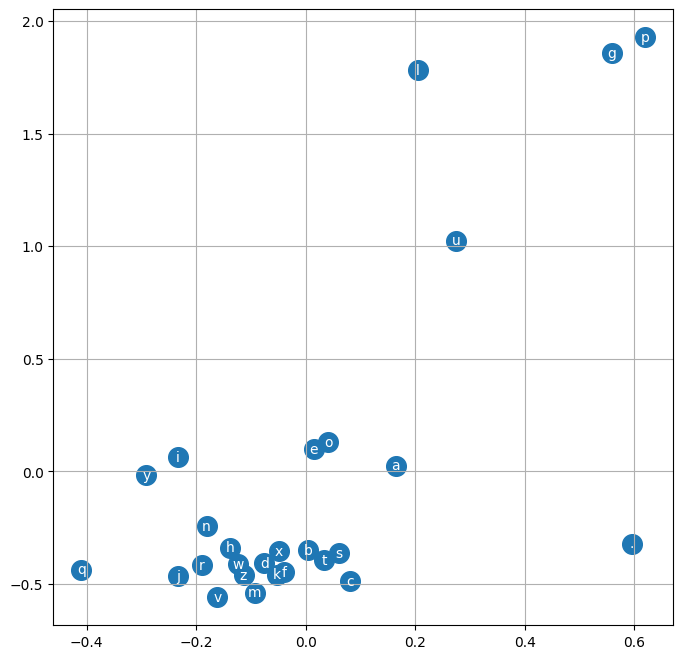

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

We can see in the diagram above that the vowels kind of cluster together in around the same space. This means the model thinks they're similar.

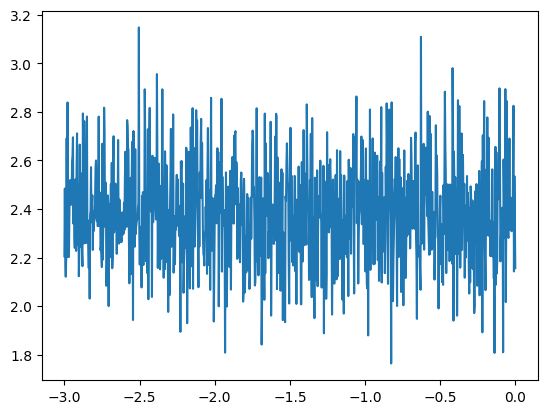

In [ ]:
plt.plot(lri, lossi)

While our loss is now much lower than when we used the bigram model (2.45), this isn't really the loss that we want. We usually like to split the data into training set, validation set, and test set.

Obviously, the training set is for training the neural net. The validation set helps us to see what hyperparameters work best. The test set is kind of the ultimate set to test and verify our loss on. It represents the data out in the wild that we would encounter. We have to be careful not to overtest on the test set--we should only test on the test set a few times, since if we keep testing our model on the test set, we risk overfitting our model that it won't owrk well on real-world data not seen before.

Below, we separate the data into three sets: training, dev/validation, and test.

In [ ]:
def build_dataset(words):
  block_size = 3    # context length: how many characters do we take to predict the next one?
  X, Y = [], []

  # we want X to be each of the first three characters, then Y to be the next character
  for word in words:

    # since 0 represents the dot, basically we initialize it to allow padding
    # context is the numeric repr of the character we're processing at hand
    context = [0] * block_size

    for ch in word + '.':
      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  return X, Y

In [ ]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# split
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

From here, I've set up most of the hyperparameters so that we can tune and run experiments to see how well the model is doing.

## Best hyperparameters:
- Embedding feature size: 11
- Hidden layer size: 200
- Batch size: 64
- Iterations: 30000
- Epoch: 3

Loss:
- Training: 2.085
- Validation: 2.1488
- **Test: 2.152**

In [ ]:
vocab_size = 27
block_size = 3
embedding_feature_size = 11
stacked_feature_size = block_size * embedding_feature_size
hidden_layer_size = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embedding_feature_size), generator=g)
W1 = torch.randn((embedding_feature_size * block_size, hidden_layer_size), generator=g)
b1 = torch.randn((1, hidden_layer_size), generator=g)
W2 = torch.randn((hidden_layer_size, vocab_size), generator=g)
b2 = torch.randn((1, vocab_size), generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"num parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
  p.requires_grad = True

num parameters: 12524


In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
batch_size = 64
initial_lr = 0.1
iterations = 30000
epochs = 3

for epoch in range(epochs):
  for i in range(iterations):
    # minibatch
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view((-1, stacked_feature_size)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # update
    lr = initial_lr if epoch < epochs / 2 else 0.01
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

  print(loss.item())

1.9989179372787476
2.2716541290283203
2.3175084590911865


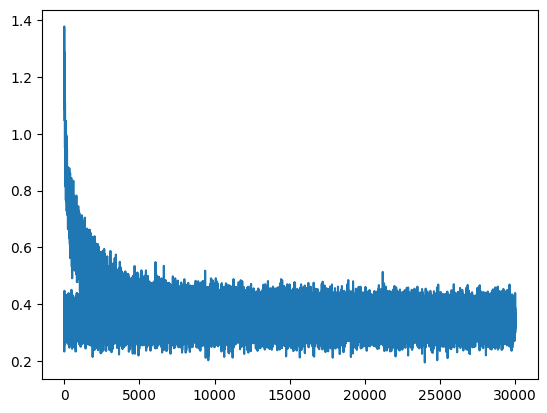

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# Evaluation on validation set
emb = C[Xval]
h = torch.tanh(emb.view((-1, stacked_feature_size)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
print(f"Validation loss: {loss.item()}")

Validation loss: 2.143494129180908


In [ ]:
# Evaluation on test set
emb = C[Xte]
h = torch.tanh(emb.view((-1, stacked_feature_size)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(f"Test loss: {loss.item()}")

Test loss: 2.1394975185394287


## Sampling From the Model

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

# generate 20 names
for _ in range(20):
  name = []
  context = [0] * block_size      # (1, 3)

  while True:
    # d = 11 (embedding feature size)
    emb = C[torch.tensor(context)]  # C: (27, d) -> emb: (block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    name.append(ix)
    if ix == 0:
      break

  print(''.join(itos[token] for token in name))


carmah.
amelle.
khi.
mrix.
taty.
sacassie.
mahnee.
den.
art.
kaeli.
nellara.
chaily.
kaleigh.
ham.
pris.
quinn.
sulivea.
jadiquinathon.
jarynix.
kaelidssa.
